[Базовая статья 1](https://medium.com/@sandha.iitr/tuning-arima-for-forecasting-an-easy-approach-in-python-5f40d55184c4)

[Базовая статья 2](https://medium.com/datainc/time-series-analysis-and-forecasting-with-arima-in-python-aa22694b3aaa)

[Базовая статья 3](https://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/)

[Базовая статья 4](https://alkaline-ml.com/pmdarima/tips_and_tricks.html)

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Загрузка данных

In [152]:
data = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")
data

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
48199,NaN,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,NaN,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,NaN,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,NaN,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450


In [153]:
data = data.drop(['rain_1h', 'snow_1h', 'clouds_all', 'weather_main', 'weather_description'], axis=1)
data

,holiday,temp,date_time,traffic_volume
0,NaN,288.28,2012-10-02 09:00:00,5545
1,NaN,289.36,2012-10-02 10:00:00,4516
2,NaN,289.58,2012-10-02 11:00:00,4767
3,NaN,290.13,2012-10-02 12:00:00,5026
4,NaN,291.14,2012-10-02 13:00:00,4918
...,...,...,...,...
48199,NaN,283.45,2018-09-30 19:00:00,3543
48200,NaN,282.76,2018-09-30 20:00:00,2781
48201,NaN,282.73,2018-09-30 21:00:00,2159
48202,NaN,282.09,2018-09-30 22:00:00,1450


###  2. EDA

In [154]:
data['date_time'] = pd.to_datetime(data['date_time'])

In [155]:
data['traffic_volume'] = data['traffic_volume'].apply(lambda x: 0.00001 if x == 0 else x)

In [156]:
data['holiday'] = data['holiday'].apply(lambda x: 1 if not pd.isnull(x) else x)

In [157]:
data['holiday'] = data['holiday'].apply(lambda x: 0 if pd.isnull(x) else x)
data

,holiday,temp,date_time,traffic_volume
0,0.0,288.28,2012-10-02 09:00:00,5545.0
1,0.0,289.36,2012-10-02 10:00:00,4516.0
2,0.0,289.58,2012-10-02 11:00:00,4767.0
3,0.0,290.13,2012-10-02 12:00:00,5026.0
4,0.0,291.14,2012-10-02 13:00:00,4918.0
...,...,...,...,...
48199,0.0,283.45,2018-09-30 19:00:00,3543.0
48200,0.0,282.76,2018-09-30 20:00:00,2781.0
48201,0.0,282.73,2018-09-30 21:00:00,2159.0
48202,0.0,282.09,2018-09-30 22:00:00,1450.0


In [158]:
data = data.drop_duplicates(subset=['date_time'])

In [159]:
data.isna().sum()

holiday           0
temp              0
date_time         0
traffic_volume    0
dtype: int64

In [160]:
min_date = data['date_time'].min()
max_date = data['date_time'].max()

In [161]:
df = pd.DataFrame({'date_time': pd.date_range(start = min_date, end = max_date, freq ='1H')})
df

,date_time
0,2012-10-02 09:00:00
1,2012-10-02 10:00:00
2,2012-10-02 11:00:00
3,2012-10-02 12:00:00
4,2012-10-02 13:00:00
...,...
52546,2018-09-30 19:00:00
52547,2018-09-30 20:00:00
52548,2018-09-30 21:00:00
52549,2018-09-30 22:00:00


In [162]:
df = pd.merge(df, data, left_on='date_time', right_on='date_time', how='left')

In [163]:
df['holiday'] = df['holiday'].apply(lambda x: 0 if pd.isnull(x) else x)

In [164]:
df = df.interpolate()

In [165]:
df.isna().sum()

date_time         0
holiday           0
temp              0
traffic_volume    0
dtype: int64

In [166]:
import datetime

In [167]:
df = df.drop(df[df.date_time < datetime.datetime(year=2018, month=8, day=1)].index)

In [168]:
from statsmodels.tsa.stattools import adfuller 

In [169]:
df.describe()

,date_time,holiday,temp,traffic_volume
count,1464,1464.000000,1464.000000,1464.000000
mean,2018-08-31 11:30:00,0.001366,292.765348,3365.406762
min,2018-08-01 00:00:00,0.000000,274.250000,219.000000
25%,2018-08-16 05:45:00,0.000000,289.017500,1386.750000
50%,2018-08-31 11:30:00,0.000000,293.395000,3656.500000
75%,2018-09-15 17:15:00,0.000000,296.620000,4928.500000
max,2018-09-30 23:00:00,1.000000,306.080000,6837.000000
std,NaN,0.036948,5.890994,1950.309003


In [170]:
df_check = df[['traffic_volume']]
df_check

,traffic_volume
51087,662.0
51088,398.0
51089,352.0
51090,409.0
51091,908.0
...,...
52546,3543.0
52547,2781.0
52548,2159.0
52549,1450.0


In [171]:
df_check.isna().sum()

traffic_volume    0
dtype: int64

In [172]:
df_check

,traffic_volume
51087,662.0
51088,398.0
51089,352.0
51090,409.0
51091,908.0
...,...
52546,3543.0
52547,2781.0
52548,2159.0
52549,1450.0


In [173]:
res = adfuller(df_check) 

In [174]:
print('Augmented Dickey-Fuller Statistic: %f' % res[0]) 
print('p-value: %f' % res[1])

Augmented Dickey-Fuller Statistic: -4.476582
p-value: 0.000217


p-value < 0.05 - ряд стационарный

In [175]:
df

,date_time,holiday,temp,traffic_volume
51087,2018-08-01 00:00:00,0.0,293.34,662.0
51088,2018-08-01 01:00:00,0.0,293.07,398.0
51089,2018-08-01 02:00:00,0.0,292.54,352.0
51090,2018-08-01 03:00:00,0.0,292.47,409.0
51091,2018-08-01 04:00:00,0.0,292.27,908.0
...,...,...,...,...
52546,2018-09-30 19:00:00,0.0,283.45,3543.0
52547,2018-09-30 20:00:00,0.0,282.76,2781.0
52548,2018-09-30 21:00:00,0.0,282.73,2159.0
52549,2018-09-30 22:00:00,0.0,282.09,1450.0


In [176]:
df.dtypes

date_time         datetime64[ns]
holiday                  float64
temp                     float64
traffic_volume           float64
dtype: object

In [177]:
from datetime import datetime, timedelta

In [178]:
df_test = df.loc[df['date_time'] > max_date.to_pydatetime() - timedelta(days=14)]
df_test

,date_time,holiday,temp,traffic_volume
52215,2018-09-17 00:00:00,0.0,296.58,550.0
52216,2018-09-17 01:00:00,0.0,296.19,280.0
52217,2018-09-17 02:00:00,0.0,295.82,260.0
52218,2018-09-17 03:00:00,0.0,295.83,344.0
52219,2018-09-17 04:00:00,0.0,295.68,880.0
...,...,...,...,...
52546,2018-09-30 19:00:00,0.0,283.45,3543.0
52547,2018-09-30 20:00:00,0.0,282.76,2781.0
52548,2018-09-30 21:00:00,0.0,282.73,2159.0
52549,2018-09-30 22:00:00,0.0,282.09,1450.0


In [179]:
df_train = df.loc[df['date_time'] <= max_date.to_pydatetime() - timedelta(days=14)]
df_train

,date_time,holiday,temp,traffic_volume
51087,2018-08-01 00:00:00,0.0,293.34,662.0
51088,2018-08-01 01:00:00,0.0,293.07,398.0
51089,2018-08-01 02:00:00,0.0,292.54,352.0
51090,2018-08-01 03:00:00,0.0,292.47,409.0
51091,2018-08-01 04:00:00,0.0,292.27,908.0
...,...,...,...,...
52210,2018-09-16 19:00:00,0.0,303.02,3400.0
52211,2018-09-16 20:00:00,0.0,300.78,3092.0
52212,2018-09-16 21:00:00,0.0,298.90,2623.0
52213,2018-09-16 22:00:00,0.0,297.85,1725.0


In [180]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [181]:
test = df.iloc[-100:]
test

,date_time,holiday,temp,traffic_volume
52451,2018-09-26 20:00:00,0.0,285.82,3197.0
52452,2018-09-26 21:00:00,0.0,284.41,3475.0
52453,2018-09-26 22:00:00,0.0,284.51,1973.0
52454,2018-09-26 23:00:00,0.0,284.86,1209.0
52455,2018-09-27 00:00:00,0.0,285.26,654.0
...,...,...,...,...
52546,2018-09-30 19:00:00,0.0,283.45,3543.0
52547,2018-09-30 20:00:00,0.0,282.76,2781.0
52548,2018-09-30 21:00:00,0.0,282.73,2159.0
52549,2018-09-30 22:00:00,0.0,282.09,1450.0


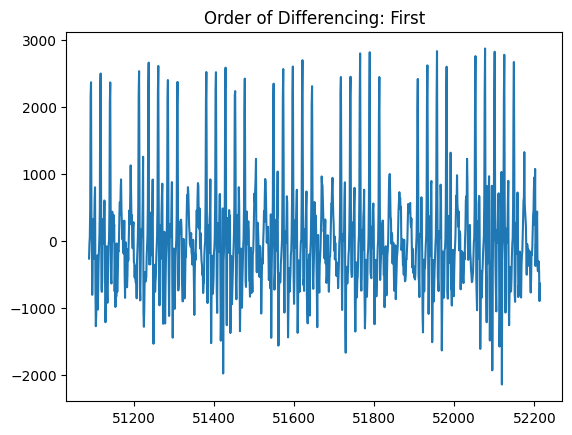

In [182]:
plt.plot(df_train['traffic_volume'].diff())
plt.title('Order of Differencing: First') 
plt.show() 

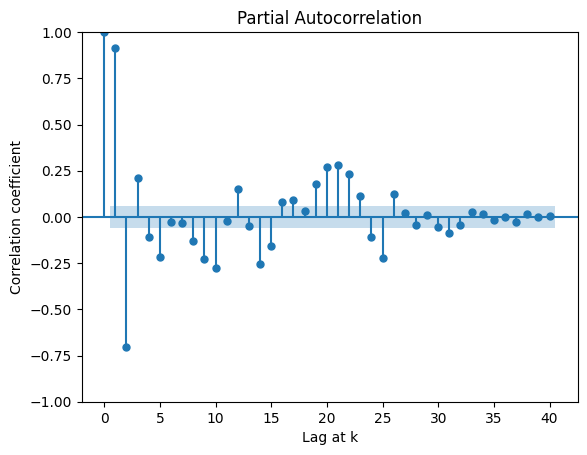

In [183]:
plot_pacf(df_train['traffic_volume'], lags=40)
plt.xlabel('Lag at k')
plt.ylabel('Correlation coefficient')
plt.show()

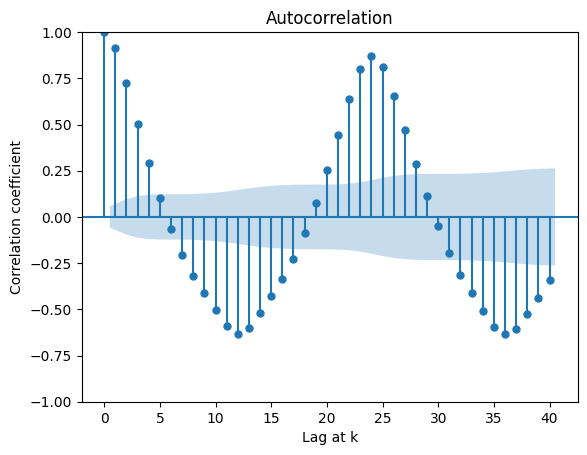

In [184]:
plot_acf(df_train['traffic_volume'], lags=40)
plt.xlabel('Lag at k')
plt.ylabel('Correlation coefficient')
plt.show()

### 3. ARIMA

In [185]:
from statsmodels.tsa.arima.model import ARIMA

In [187]:
model = ARIMA(df['traffic_volume'], order = (1, 0, 1), seasonal_order=(1, 0, 1, 24*7)) #(p,d,q) (P,D,Q,s)
result = model.fit() 
print(result.summary()) 

                                     SARIMAX Results                                     
Dep. Variable:                    traffic_volume   No. Observations:                 1464
Model:             ARIMA(1, 0, 1)x(1, 0, 1, 168)   Log Likelihood              -10406.296
Date:                           Thu, 11 Jul 2024   AIC                          20824.592
Time:                                   19:39:50   BIC                          20856.326
Sample:                                        0   HQIC                         20836.428
                                          - 1464                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3365.4037    269.270     12.498      0.000    2837.643    3893.164
ar.L1          0.7398      0.017     43.129

In [ ]:
test_forecast = result.forecast(steps=len(df_test), index=df_test.index)

In [ ]:
test_forecast

52215     410.608888
52216     221.830241
52217     183.080158
52218     261.642932
52219     772.124670
            ...     
52546    3449.440696
52547    2985.363840
52548    2462.837719
52549    1789.185979
52550    1279.745952
Name: predicted_mean, Length: 336, dtype: float64

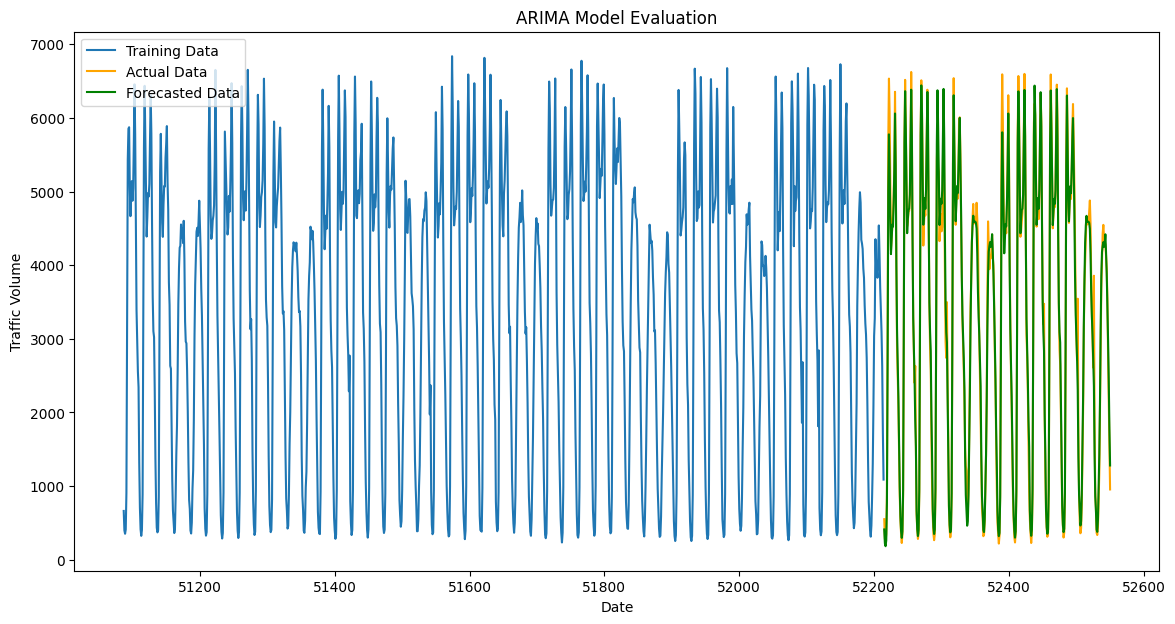

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(df_train['traffic_volume'], label='Training Data')
plt.plot(df_test['traffic_volume'], label='Actual Data', color='orange')
plt.plot(test_forecast, label='Forecasted Data', color='green')
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Traffic Volume')
plt.legend()
plt.show()

### 4. Выводы

По-моему результат отличный. Можно ещё поиграться признаками p, q. 